In [9]:
from pathlib import Path

candidates = list(Path(".").rglob("*matched*argo*bgc*profiles*bbp*.csv"))
for p in candidates[:10]:
    print(p)

Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv


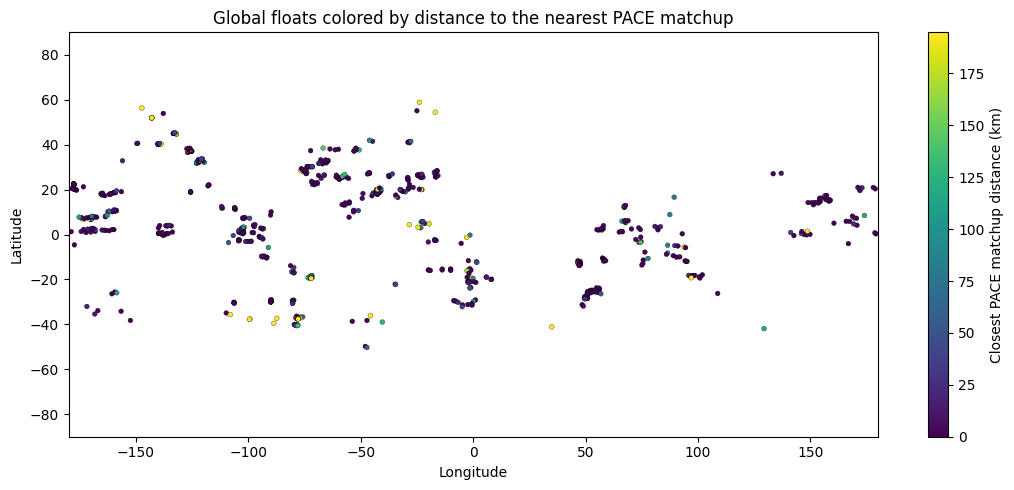

In [4]:
# === CONFIG ===
CSV_IN   = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv"
CSV_OUT  = "float_min_distance.csv"
PNG_OUT  = "global_float_distance.png"
CMAP     = "viridis"
POINT_SZ = 12
ROBUST_P = 95

import pandas as pd, numpy as np, matplotlib.pyplot as plt, re, os
from pathlib import Path

assert Path(CSV_IN).exists(), f"File not found: {CSV_IN}"

# --- Load & normalize column names ---
df = pd.read_csv(CSV_IN)
df.columns = [c.strip() for c in df.columns]
lower = {c: re.sub(r"\s+", "_", c.strip().lower()) for c in df.columns}
df.rename(columns=lower, inplace=True)

def pick(cols, pats):
    for p in pats:
        for c in cols:
            if re.search(p, c):
                return c
    return None

cols = df.columns.tolist()

# Float coords & ID
float_lat = pick(cols, [r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"^lat_?float$", r"^lat$"])
float_lon = pick(cols, [r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"^lon_?float$", r"^lon$"])
float_id  = pick(cols, [r"^wmo$", r"platform(_number)?$", r"^float_id$", r"^argo_id$"])

# PACE coords (only used if no distance column)
pace_lat  = pick(cols, [r"^pace_?lat$", r"^match_?lat$", r"^sat_?lat$", r"^oci_?lat$", r"^granule_?lat$", r"^l2_?lat$"])
pace_lon  = pick(cols, [r"^pace_?lon$", r"^match_?lon$", r"^sat_?lon$", r"^oci_?lon$", r"^granule_?lon$", r"^l2_?lon$"])

# Precomputed distance?
dist_col = pick(cols, [r"(distance|dist|separation).*km$", r"^(distance|dist|separation)$"])

# --- Compute great-circle distance (km) if needed ---
def haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371.0 * (2*np.arcsin(np.sqrt(a)))

if dist_col is None:
    if not (float_lat and float_lon and pace_lat and pace_lon):
        raise ValueError
    def norm_lon(x): return ((np.asarray(x, float) + 180) % 360) - 180
    flon = norm_lon(df[float_lon])
    plon = norm_lon(df[pace_lon])
    flat = df[float_lat].astype(float)
    plat = df[pace_lat].astype(float)
    df["distance_km"] = haversine_km(flat, flon, plat, plon)
    dist_col = "distance_km"

# --- Per-float key (prefer WMO/ID, else rounded lat/lon) ---
if float_id:
    df["_float_key"] = df[float_id].astype(str)
else:
    if not (float_lat and float_lon):
        raise ValueError
    df["_float_key"] = (df[float_lat].astype(float).round(2).astype(str) + "," +
                        df[float_lon].astype(float).round(2).astype(str))

# --- Reduce to one row per float: min distance + median location ---
agg = (df.groupby("_float_key")
         .agg(lat=(float_lat, "median"),
              lon=(float_lon, "median"),
              min_distance_km=(dist_col, "min"))
         .reset_index(drop=True))

# Normalize lon to [-180, 180]
agg["lon"] = ((agg["lon"] + 180) % 360) - 180

# --- Color scale robust to outliers ---
v = np.nanpercentile(agg["min_distance_km"], ROBUST_P)
vmax = float(v) if np.isfinite(v) and v > 0 else float(agg["min_distance_km"].max() or 1.0)

# --- Plot ---
plt.figure(figsize=(11,5))
sc = plt.scatter(agg["lon"], agg["lat"],
                 c=agg["min_distance_km"], s=POINT_SZ,
                 cmap=CMAP, vmin=0, vmax=vmax,
                 edgecolors="k", linewidths=0.2)
plt.xlim(-180, 180); plt.ylim(-90, 90)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
cb = plt.colorbar(sc); cb.set_label("Closest PACE matchup distance (km)")
plt.title("Global floats colored by distance to the nearest PACE matchup")
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=200)
plt.show()

/opt/anaconda3/envs/earthaccess-env/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


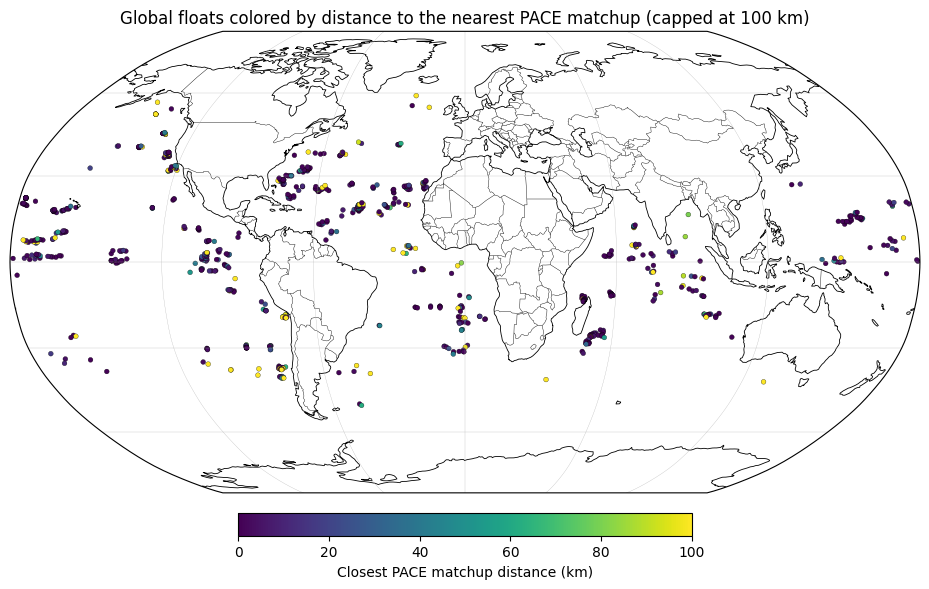

In [6]:
# === CONFIG ===
CSV_IN   = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv"
CSV_OUT  = "float_min_distance.csv"          # per-float table to save
PNG_OUT  = "global_float_distance.png"       # map image to save
CMAP     = "viridis"
POINT_SZ = 12
VMIN, VMAX = 0.0, 100.0                      # <-- cap at 0..100 km

import pandas as pd, numpy as np, matplotlib.pyplot as plt, re

# --- Load & normalize column names ---
df = pd.read_csv(CSV_IN)
df.columns = [c.strip() for c in df.columns]
lower = {c: re.sub(r"\s+", "_", c.strip().lower()) for c in df.columns}
df.rename(columns=lower, inplace=True)

def pick(cols, pats):
    for p in pats:
        for c in cols:
            if re.search(p, c):
                return c
    return None

cols = df.columns.tolist()

# Float coords & ID
float_lat = pick(cols, [r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"^lat_?float$", r"^lat$"])
float_lon = pick(cols, [r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"^lon_?float$", r"^lon$"])
float_id  = pick(cols, [r"^wmo$", r"platform(_number)?$", r"^float_id$", r"^argo_id$"])

# PACE coords (only used if no distance column)
pace_lat  = pick(cols, [r"^pace_?lat$", r"^match_?lat$", r"^sat_?lat$", r"^oci_?lat$", r"^granule_?lat$", r"^l2_?lat$"])
pace_lon  = pick(cols, [r"^pace_?lon$", r"^match_?lon$", r"^sat_?lon$", r"^oci_?lon$", r"^granule_?lon$", r"^l2_?lon$"])

# Precomputed distance?
dist_col = pick(cols, [r"(distance|dist|separation).*km$", r"^(distance|dist|separation)$"])

# --- Compute great-circle distance (km) if needed ---
def haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371.0 * (2*np.arcsin(np.sqrt(a)))  # Earth radius 6371 km

if dist_col is None:
    if not (float_lat and float_lon and pace_lat and pace_lon):
        raise ValueError("Couldn't find enough columns to compute distance. "
                         "Need float & PACE lat/lon OR an existing distance column.")
    def norm_lon(x): return ((np.asarray(x, float) + 180) % 360) - 180
    df["distance_km"] = haversine_km(df[float_lat].astype(float),
                                     norm_lon(df[float_lon]),
                                     df[pace_lat].astype(float),
                                     norm_lon(df[pace_lon]))
    dist_col = "distance_km"

# --- Per-float key (prefer WMO/ID, else rounded lat/lon) ---
if float_id:
    df["_float_key"] = df[float_id].astype(str)
else:
    if not (float_lat and float_lon):
        raise ValueError("Missing float coordinates for fallback grouping.")
    df["_float_key"] = (df[float_lat].astype(float).round(2).astype(str) + "," +
                        df[float_lon].astype(float).round(2).astype(str))

# --- Reduce to one row per float: min distance + median location ---
agg = (df.groupby("_float_key")
         .agg(lat=(float_lat, "median"),
              lon=(float_lon, "median"),
              min_distance_km=(dist_col, "min"))
         .reset_index(drop=True))

# Normalize lon for plotting
agg["lon"] = ((agg["lon"] + 180) % 360) - 180

# --- Plot with coastlines (Cartopy); fallback to plain scatter if not available ---
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.gridlines(draw_labels=False, linewidth=0.2)

    sc = ax.scatter(agg["lon"], agg["lat"],
                    c=agg["min_distance_km"], s=POINT_SZ,
                    cmap=CMAP, vmin=VMIN, vmax=VMAX,
                    transform=ccrs.PlateCarree(),
                    edgecolors="k", linewidths=0.2)

    cb = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.04, fraction=0.045)
    cb.set_label("Closest PACE matchup distance (km)")
    plt.title("Global floats colored by distance to the nearest PACE matchup (capped at 100 km)")
    plt.tight_layout()
    plt.savefig(PNG_OUT, dpi=200)
    plt.show()

except Exception as e:
    print("(Cartopy not available; plotting without coastlines)\nReason:", e)
    plt.figure(figsize=(11,5))
    sc = plt.scatter(agg["lon"], agg["lat"],
                     c=agg["min_distance_km"], s=POINT_SZ,
                     cmap=CMAP, vmin=VMIN, vmax=VMAX,
                     edgecolors="k", linewidths=0.2)
    plt.xlim(-180, 180); plt.ylim(-90, 90)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    cb = plt.colorbar(sc); cb.set_label("Closest PACE matchup distance (km)")
    plt.title("Global floats colored by distance to the nearest PACE matchup (capped at 100 km)")
    plt.tight_layout()
    plt.savefig(PNG_OUT, dpi=200)
    plt.show()

In [7]:
import pandas as pd
import numpy as np
import re

CSV_IN = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv"

df = pd.read_csv(CSV_IN)
cols = {c.lower().strip().replace(" ", "_"): c for c in df.columns}

def pick(*pats):
    for p in pats:
        for k in cols:
            if re.search(p, k):
                return cols[k]
    return None

# Use a precomputed distance column if present; otherwise compute from float↔PACE coords like before
dist_c = pick(r"(distance|dist|separation).*km$", r"^(distance|dist|separation)$")
if dist_c is None:
    # try to compute distances
    lat_f  = pick(r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"\b(lat|latitude)\b")
    lon_f  = pick(r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"\b(lon|longitude)\b")
    lat_p  = pick(r"^pace_?lat$", r"^match_?lat$", r"^sat_?lat$", r"^oci_?lat$", r"^l2_?lat$")
    lon_p  = pick(r"^pace_?lon$", r"^match_?lon$", r"^sat_?lon$", r"^oci_?lon$", r"^l2_?lon$")
    if not all([lat_f, lon_f, lat_p, lon_p]):
        raise ValueError("Need a distance column or float & PACE lat/lon to compute distances.")
    def norm(x): return ((np.asarray(x, float) + 180) % 360) - 180
    def haversine_km(a1, b1, a2, b2):
        a1, b1, a2, b2 = map(np.radians, [a1, b1, a2, b2])
        dlon, dlat = b2 - b1, a2 - a1
        h = np.sin(dlat/2)**2 + np.cos(a1)*np.cos(a2)*np.sin(dlon/2)**2
        return 6371.0 * (2*np.arcsin(np.sqrt(h)))
    df["distance_km"] = haversine_km(df[lat_f], norm(df[lon_f]), df[lat_p], norm(df[lon_p]))
    dist_c = "distance_km"

d = df[dist_c].astype(float).dropna().values

# Summary stats that answer “where the majority are”
p25, p50, p75 = np.percentile(d, [25, 50, 75])
p90 = np.percentile(d, 90)
under_25  = np.mean(d <= 25)  * 100
under_50  = np.mean(d <= 50)  * 100
under_100 = np.mean(d <= 100) * 100

print(f"Total matchups: {d.size}")
print(f"Median (50th pct): {p50:.1f} km")
print(f"IQR (25th–75th): {p25:.1f}–{p75:.1f} km")
print(f"90th percentile: {p90:.1f} km")
print(f"≤ 25 km:  {under_25:5.1f}% of matchups")
print(f"≤ 50 km:  {under_50:5.1f}% of matchups")
print(f"≤ 100 km: {under_100:5.1f}% of matchups")

Total matchups: 812
Median (50th pct): 2.1 km
IQR (25th–75th): 0.6–19.4 km
90th percentile: 100.4 km
≤ 25 km:   78.1% of matchups
≤ 50 km:   84.4% of matchups
≤ 100 km:  89.9% of matchups


In [8]:
bins = np.arange(0, max(100, d.max()) + 10, 10)
hist, edges = np.histogram(d, bins=bins)
imax = hist.argmax()
print(f"Most populated bin: {edges[imax]:.0f}–{edges[imax+1]:.0f} km "
      f"({hist[imax]} matchups, {100*hist[imax]/d.size:.1f}%)")

Most populated bin: 0–10 km (565 matchups, 69.6%)
